In [1]:
#librerias necesarias
from google.colab import drive
# Montar Google Drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import sklearn

# Modulos especificos de scikit-learn(modelo de ml)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix





Mounted at /content/drive


- 1. Entendimiento del Problema:
Definición del Problema: Definir claramente el problema de detección de fraudes y los objetivos del proyecto.
Conjunto de Datos: Familiarízarse con el conjunto de datos, comprende las columnas y la naturaleza de los datos.

In [2]:
df= pd.read_csv('/content/drive/MyDrive/Deteccion de Fraudes/transactions_train.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [3]:
mapeo_nombres={
    'step': 'paso_del_tiempo',
    'type': 'tipo',
    'amount':'monto_transaccion',
    'nameOrig':'id_cliente',
    'oldbalanceOrig':'saldo_anterior_cliente',
    'newbalanceOrig': 'saldo_posterior_cliente',
    'nameDest':'id_destinatario',
    'oldbalanceDest':'saldo_anterior_Dest',
    'newbalanceDest':'saldo_posterior_Dest',
    'isFraud':'es_fraude'
}
df.rename(columns=mapeo_nombres, inplace=True)

In [5]:
tamaño= df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6351193 entries, 0 to 6351192
Data columns (total 10 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   paso_del_tiempo          int64  
 1   tipo                     object 
 2   monto_transaccion        float64
 3   id_cliente               object 
 4   saldo_anterior_cliente   float64
 5   saldo_posterior_cliente  float64
 6   id_destinatario          object 
 7   saldo_anterior_Dest      float64
 8   saldo_posterior_Dest     float64
 9   es_fraude                int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 484.6+ MB


In [7]:
df.describe()

,paso_del_tiempo,monto_transaccion,saldo_anterior_cliente,saldo_posterior_cliente,saldo_anterior_Dest,saldo_posterior_Dest,es_fraude
count,6.351193e+06,6.351193e+06,6.351193e+06,6.351193e+06,6.351193e+06,6.351193e+06,6.351193e+06
mean,2.425553e+02,1.798155e+05,8.347957e+05,8.561696e+05,1.101043e+06,1.225372e+06,1.215047e-03
std,1.410676e+02,6.036310e+05,2.889959e+06,2.926073e+06,3.398924e+06,3.674293e+06,3.483635e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.550000e+02,1.338829e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.380000e+02,7.486483e+04,1.415300e+04,0.000000e+00,1.330865e+05,2.149190e+05,0.000000e+00
75%,3.340000e+02,2.087152e+05,1.073460e+05,1.443651e+05,9.438661e+05,1.112791e+06,0.000000e+00
max,6.990000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


***Revision de estadisticas descriptivas:***

---

\
- 'monto_transaccion': si vemos el min a max va de 0 a 92.445.520, con una media de aproximadamente 179.815,5 y una separación estandar de aproximadamente 603.631.
Parece haber una gran variabilidad en los montos de las transacciones, con un valor máximo significativamente mayor que la media. Podrían haber valores atípicos.
- 'columnas de saldos': todas parecen tener gran variabilidad, ya que van desde 0 a millones. Algo a destacar es que la media esta muy por debajo del maximo.

- 'es_fraude': la columna parece ser muy desequilibrada, ya que la media es muy baja (alrededor de 0.0012). Esto sugiere que la mayoria de las transacciones no son fraudulentas.



In [8]:
df.isnull().sum()#no hay datos nulos

paso_del_tiempo            0
tipo                       0
monto_transaccion          0
id_cliente                 0
saldo_anterior_cliente     0
saldo_posterior_cliente    0
id_destinatario            0
saldo_anterior_Dest        0
saldo_posterior_Dest       0
es_fraude                  0
dtype: int64

In [18]:
conteo_fraudes = df['es_fraude'].sum()
conteo_fraudes

7717


- 2. Exploración y Procesamiento de Datos:
Exploración Inicial: Realiza una exploración inicial de los datos para entender la distribución de las variables. Contempla estandarizacion, faltantes y codificacion de variables.
Visualizaciones: Utiliza gráficos y visualizaciones para identificar patrones o anomalías en los datos.

In [4]:
# para identificar los valores atipicos tomare la columna monto transaccion
Q1 = df['monto_transaccion'].quantile(0.25)
Q3 = df['monto_transaccion'].quantile(0.75)
IQR = Q3 - Q1

#limites para identificarlos
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

#se identificane esos valores
valores_atipicos = df[(df['monto_transaccion'] < limite_inferior) | (df['monto_transaccion'] > limite_superior)]
valores_atipicos


,paso_del_tiempo,tipo,monto_transaccion,id_cliente,saldo_anterior_cliente,saldo_posterior_cliente,id_destinatario,saldo_anterior_Dest,saldo_posterior_Dest,es_fraude
85,1,TRANSFER,1505626.01,C926859124,0.00,0.0,C665576141,29031.00,5515763.34,0
86,1,TRANSFER,554026.99,C1603696865,0.00,0.0,C766572210,579285.56,0.00,0
88,1,TRANSFER,761507.39,C412788346,0.00,0.0,C1590550415,1280036.23,19169204.93,0
89,1,TRANSFER,1429051.47,C1520267010,0.00,0.0,C1590550415,2041543.62,19169204.93,0
93,1,TRANSFER,583848.46,C1839168128,0.00,0.0,C1286084959,667778.00,2107778.11,0
...,...,...,...,...,...,...,...,...,...,...
6351176,699,TRANSFER,808134.52,C1289719364,0.00,0.0,C901371341,2044669.92,2852804.45,0
6351179,699,TRANSFER,716298.41,C778044667,0.00,0.0,C1136379970,7578526.20,8294824.61,0
6351180,699,TRANSFER,549094.49,C519897821,0.00,0.0,C1595954485,628327.62,1177422.11,0
6351190,699,TRANSFER,2763398.31,C577803442,2763398.31,0.0,C619602282,0.00,0.00,1


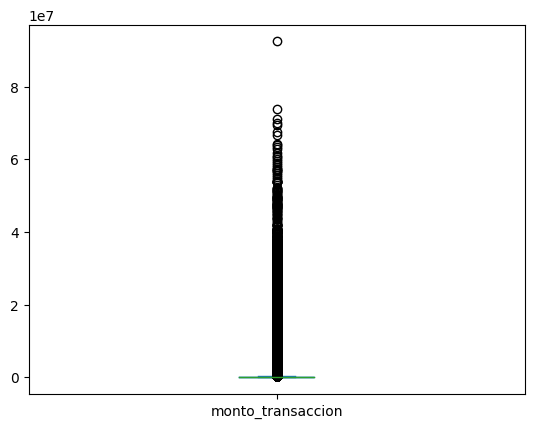

In [21]:
import matplotlib.pyplot as plt

df['monto_transaccion'].plot(kind='box')
plt.show()


***Para poder trabajar mejor con los datos, procedere a estandarizar.***

---

- monto_transacción:
Dado que representa el monto de la transacción, puede tener una escala diferente a otras columnas.

- saldo_anterior_cliente, saldo_posterior_cliente, saldo_anterior_Dest, saldo_posterior_Dest: esatn relacionadas con montos de dinero y pueden tener escalas diferentes.

Ajustare las escalas de esas columnas para que tengan una media de 0 y una desviación estándar de 1.

In [5]:
from sklearn.preprocessing import StandardScaler

columnas_a_estandarizar = ['monto_transaccion', 'saldo_anterior_cliente', 'saldo_posterior_cliente', 'saldo_anterior_Dest', 'saldo_posterior_Dest']

scaler = StandardScaler()
df[columnas_a_estandarizar] = scaler.fit_transform(df[columnas_a_estandarizar])


In [23]:
df

,paso_del_tiempo,tipo,monto_transaccion,id_cliente,saldo_anterior_cliente,saldo_posterior_cliente,id_destinatario,saldo_anterior_Dest,saldo_posterior_Dest,es_fraude
0,1,PAYMENT,-0.281589,C1231006815,-0.229989,-0.237818,M1979787155,-0.323939,-0.333499,0
1,1,PAYMENT,-0.294801,C1666544295,-0.281508,-0.285975,M2044282225,-0.323939,-0.333499,0
2,1,TRANSFER,-0.297590,C1305486145,-0.288798,-0.292600,C553264065,-0.323939,-0.333499,1
3,1,CASH_OUT,-0.297590,C840083671,-0.288798,-0.292600,C38997010,-0.317707,-0.333499,1
4,1,PAYMENT,-0.278560,C2048537720,-0.274482,-0.282387,M1230701703,-0.323939,-0.333499,0
...,...,...,...,...,...,...,...,...,...,...
6351188,699,TRANSFER,-0.028973,C1557504343,-0.232692,-0.292600,C404511346,-0.323939,-0.333499,1
6351189,699,CASH_OUT,-0.028973,C1532317723,-0.232692,-0.292600,C446134087,-0.323939,-0.289320,1
6351190,699,TRANSFER,4.280070,C577803442,0.667346,-0.292600,C619602282,-0.323939,-0.333499,1
6351191,699,CASH_OUT,4.280070,C1491503658,0.667346,-0.292600,C454424230,-0.224050,0.510994,1


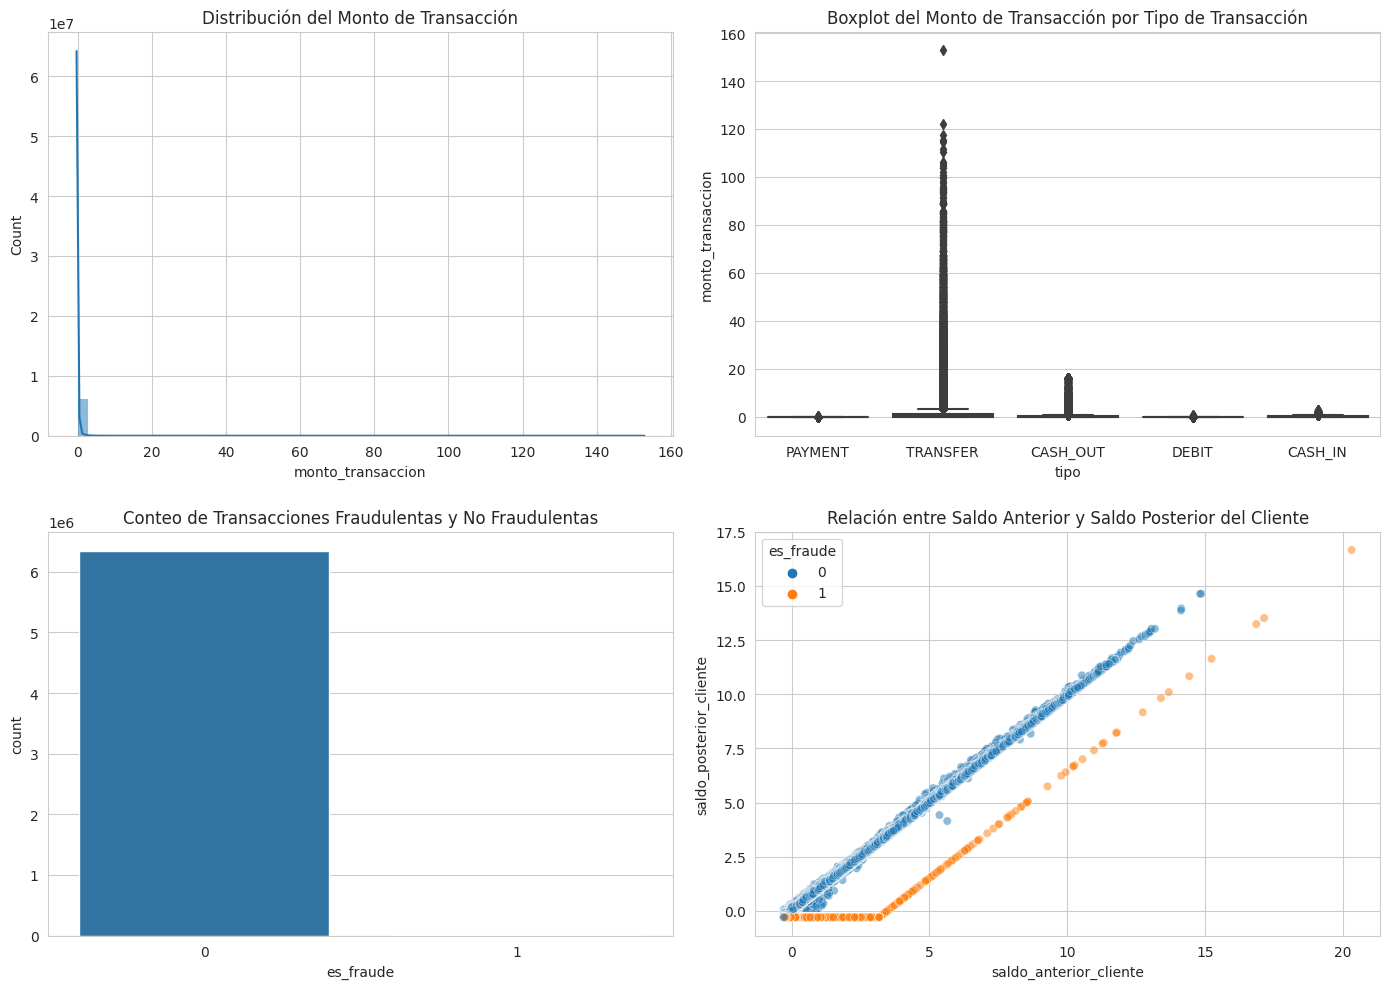

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# subgraficos
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Histograma del monto de transacción
sns.histplot(df['monto_transaccion'], bins=50, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribución del Monto de Transacción')

# Boxplot de monto de transacción por tipo de transacción
sns.boxplot(x='tipo', y='monto_transaccion', data=df, ax=axs[0, 1])
axs[0, 1].set_title('Boxplot del Monto de Transacción por Tipo de Transacción')

# Grafico de barras para contar transacciones fraudulentas y no fraudulentas
sns.countplot(x='es_fraude', data=df, ax=axs[1, 0])
axs[1, 0].set_title('Conteo de Transacciones Fraudulentas y No Fraudulentas')

#Grafico dispercion
sns.scatterplot(x='saldo_anterior_cliente', y='saldo_posterior_cliente', data=df, hue='es_fraude', alpha=0.5, ax=axs[1,1])
axs[1,1].set_title('Relación entre Saldo Anterior y Saldo Posterior del Cliente')


# Ajustar el diseño y mostrar la figura
plt.tight_layout()

#ver :)
plt.show()


- Correlacion entre variables

<ipython-input-29-8f48b6de2ff8>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')


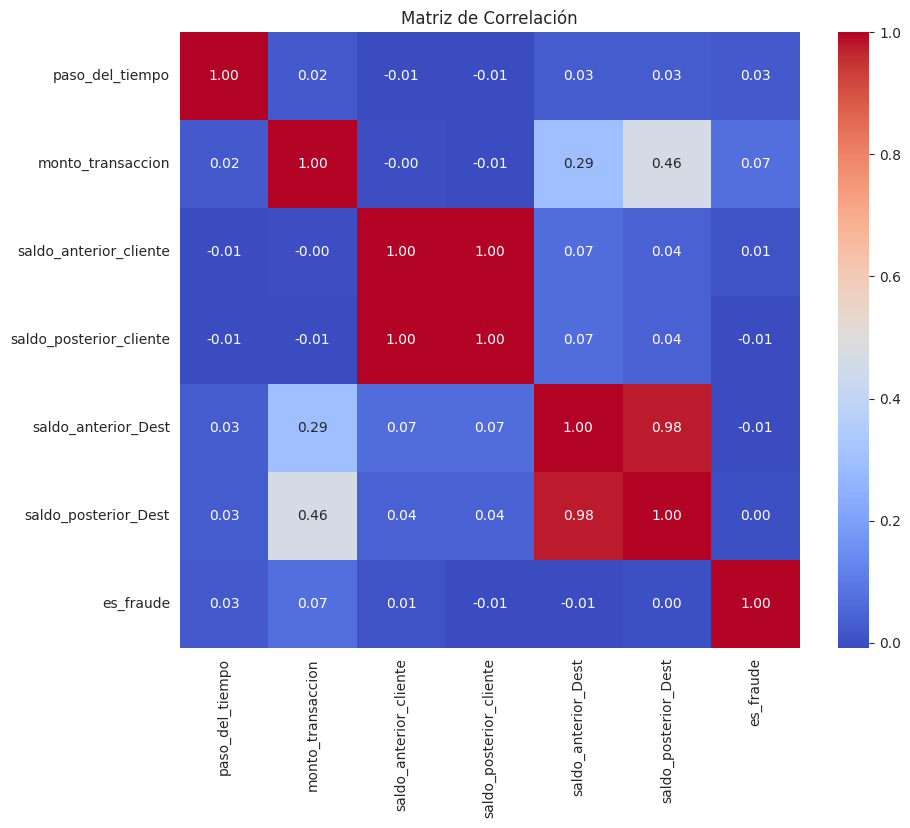

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()


Codificacion de la variable tipo de transaccion


In [6]:
df = pd.get_dummies(df, columns=['tipo'], prefix='tipo')


In [ ]:
X = df.drop(['es_fraude', 'id_destinatario', 'id_cliente'], axis=1)
y = df['es_fraude']  # variable objetivo 'es_fraude'

# Divido los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenamiento del modelo
model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Evaluamos el rendimiento del modelo
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))


# **Propósito del Ajuste del Umbral:**
El ajuste del umbral permite modificar la sensibilidad del modelo a la hora de clasificar instancias como positivas o negativas. Cambiar el umbral puede afectar las tasas de falsos positivos y falsos negativos, y por lo tanto, ajustar la precisión y el recuerdo del modelo.

Experimentar con diferentes umbrales te permite encontrar un equilibrio que se ajusta a los objetivos específicos.
\
En este caso priorice reducir los falsos negativos (transacciones fraudulentas clasificadas incorrectamente como no fraudulentas),disminuyendo el umbral. En el caso de querer reducir los falsos positivos (transacciones no fraudulentas clasificadas incorrectamente como fraudulentas),deberiamos aumentar el umbral.  

In [50]:
# Probabilidades predichas para la clase positiva
proba_fraude = model.predict_proba(X_test)[:, 1]

# Ajuste del umbral
nuevo_umbral = 0.3
y_pred_ajustado = (proba_fraude > nuevo_umbral).astype(int)

# Evaluacion del rendimiento con el nuevo umbral
print("Classification Report con nuevo umbral:\n", classification_report(y_test, y_pred_ajustado))
print("Confusion Matrix con nuevo umbral:\n", confusion_matrix(y_test, y_pred_ajustado))


Classification Report con nuevo umbral:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1268695
           1       0.94      0.86      0.89      1544

    accuracy                           1.00   1270239
   macro avg       0.97      0.93      0.95   1270239
weighted avg       1.00      1.00      1.00   1270239

Confusion Matrix con nuevo umbral:
 [[1268604      91]
 [    223    1321]]


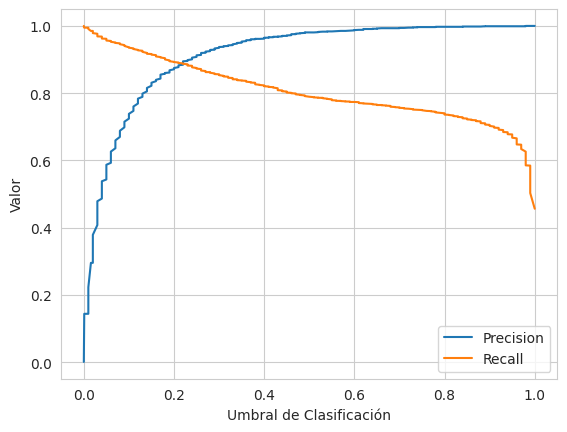

In [49]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, proba_fraude)

# Grafico de la curva de precisión y recall
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Umbral de Clasificación')
plt.ylabel('Valor')
plt.legend()
plt.show()


In [ ]:
# Creo un DataFrame con nuevas filas basadas en el esquema existente
nuevos_datos = pd.DataFrame({
    'paso_del_tiempo': np.random.randint(1, 700, size=6351193),
    'tipo': np.random.choice(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT'], size=6351193),
    'monto_transaccion': np.random.uniform(-0.3, 4.3, size=6351193),
    'id_cliente': np.random.choice(['C1231006815', 'C1666544295', 'C1305486145', 'C840083671', 'C2048537720'], size=6351193),
    'saldo_anterior_cliente': np.random.uniform(-0.3, 0.67, size=6351193),
    'saldo_posterior_cliente': np.random.uniform(-0.3, 0.67, size=6351193),
    'id_destinatario': np.random.choice(['M1979787155', 'M2044282225', 'C553264065', 'C38997010', 'M1230701703'], size=6351193),
    'saldo_anterior_Dest': np.random.uniform(-0.32, -0.22, size=6351193),
    'saldo_posterior_Dest': np.random.uniform(-0.34, 0.51, size=6351193),
    'es_fraude': np.random.choice([0, 1], size=6351193)
})
print(nuevos_datos.head())


In [ ]:
nuevas_predicciones = model.predict(nuevos_datos)